## I. Data Setting

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf

tf.__version__

'2.9.2'

In [3]:
print('GPU Information -', tf.test.gpu_device_name(), '\n')

!nvidia-smi

GPU Information - /device:GPU:0 

Fri Nov 18 01:28:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    25W /  70W |    312MiB / 15109MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                      

### 1) Google Drive Mount

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!ls -l '/content/drive/My Drive/Colab Notebooks/datasets/face_data.zip'

-rw------- 1 root root 2500411368 Nov 17 05:49 '/content/drive/My Drive/Colab Notebooks/datasets/face_data.zip'


### 2) Unzip

In [6]:
!unzip /content/drive/My\ Drive/Colab\ Notebooks/datasets/face_data.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
         continuing with "central" filename version
  inflating: four_original_classes/neutral_original_image/162_ddce63cf979bcffe75e72eb7ab4eb802fe98e253e7cef396fce80a4fb8831c8b_여_20_중립_상업시설&점포&시장_20210204171343-003-004.jpg  
four_original_classes/neutral_original_image/163_03f84d01e35a8d2beed4c9467a82c212daa05809d0bc980865765fe6b0f2e9cd_남_20_중립_숙박 및 거주공간_20210201172559-010-004.jpg:  mismatching "local" filename (four_original_classes/neutral_original_image/163_03f84d01e35a8d2beed4c9467a82c212daa05809d0bc980865765fe6b0f2e9cd_ыВи_20_ьдСыж╜_ьИЩы░Х ы░П ъ▒░ьг╝ъ│╡ъ░Д_20210201172559-010-004.jpg),
         continuing with "central" filename version
  inflating: four_original_classes/neutral_original_image/163_03f84d01e35a8d2beed4c9467a82c212daa05809d0bc980865765fe6b0f2e9cd_남_20_중립_숙박 및 거주공간_20210201172559-010-004.jpg  
four_original_classes/neutral_original_image/164_777573a7e5358710c5d56335afbdbdbf7c4e61f4c6f77122675267720f909f3e_여_20_중립_숙박 및 거주공간_2021020

In [7]:
!ls -l

total 16
drwx------ 5 root root 4096 Nov 18 01:29 drive
drwxr-xr-x 6 root root 4096 Nov 18 01:29 four_croppped_classes
drwxr-xr-x 6 root root 4096 Nov 18 01:30 four_original_classes
drwxr-xr-x 1 root root 4096 Nov 16 14:35 sample_data


## II. Data Preprocessing

### 1) split-folders로 이미지 데이터 분리하기
- 6 : 2 : 2

In [8]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import splitfolders

splitfolders.ratio('four_original_classes', output="split", seed=1337, ratio=(.6, 0.2,0.2)) 

Copying files: 3520 files [00:13, 256.20 files/s]


### 2) Image_File Directory Setting
- train_dir
- valid_dir
- test_dir

In [10]:
train_dir = 'split/train' # /content/split/train
valid_dir = 'split/val'
test_dir  = 'split/test'

### 3) ImageDataGenerator( ) & flow_from_directory( )

#### Normalization & Augmentation
- ImageDataGenerator()

#### Resizing & Generator
- flow_from_directory()

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255)

valid_datagen = ImageDataGenerator(rescale = 1./255)

# With Augmentation
train_generator = train_datagen.flow_from_directory(
                  train_dir,  
                  target_size = (150, 150), 
                  batch_size = 32, 
                  class_mode = 'categorical')  

valid_generator = valid_datagen.flow_from_directory(
                  valid_dir,
                  target_size = (150, 150),
                  batch_size = 32,
                  class_mode = 'categorical')

Found 2112 images belonging to 4 classes.
Found 704 images belonging to 4 classes.


### 4) Test train_generator

In [12]:
for data_batch, labels_batch in train_generator:
    print('배치 데이터 크기:', data_batch.shape)
    print('배치 레이블 크기:', labels_batch.shape)
    break

배치 데이터 크기: (32, 150, 150, 3)
배치 레이블 크기: (32, 4)


## III. Import VGG-16 Model & Some Layers Freezing

### 1) conv_base

In [13]:
from tensorflow.keras.applications import ResNet50V2

conv_base = ResNet50V2(weights = 'imagenet',
                  include_top = False, # DNN 제외 
                  input_shape = (150, 150, 3)) # input shape을 여기서 바꾼다 

94668760/94668760 [==============================] - 1s 0us/step


### 2) Model Information

In [14]:
# conv_base.summary()

### 3) 'block5_conv1' Freezing

* Before 'weight' Freezing

In [15]:
# print('conv_base 동결 전 훈련 가능 가중치의 종류:', len(conv_base.trainable_weights))

* 'weight' Freezing

In [ ]:
# set_trainable = False # 일단 다 freeze 시킨다 

# for layer in conv_base.layers:
#     if layer.name == 'block5_conv1': # 오직 block5_conv1 만 train 시키게 한다 
#         set_trainable = True
        
#     if set_trainable:
#         layer.trainable = True
#     else:
#         layer.trainable = False

* After 'weight' Freezing

### 4) Test train_generator

In [ ]:
# print('conv_base 동결 후 훈련 가능 가중치의 종류:', len(conv_base.trainable_weights))

In [ ]:
# conv_base.summary()

## IV. CNN Keras Modeling

### 1) Model Define
- Feature Extraction & Classification

In [16]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(conv_base)

model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation = 'softmax'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 256)               13107456  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 36,673,284
Trainable params: 36,627,844
Non-trainable params: 45,440
_________________________________________________________________


### 2) Model Compile
- 모델 학습방법 설정

In [18]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam', # adam
              metrics = ['accuracy'])

### 3) Model fit
- 모델 학습 수행

In [19]:
%%time
# fitting을 할때 데이터를 만들어가며 한다 
Hist_dandc = model.fit(train_generator, 
                       epochs = 40,  
                       validation_data = valid_generator,
                       validation_steps = 50) # 20 x 50 = 1000장이기에 50번 돌려준다 

Epoch 1/40
66/66 [==============================] - ETA: 0s - loss: 1.8896 - accuracy: 0.2562

66/66 [==============================] - 297s 4s/step - loss: 1.8896 - accuracy: 0.2562 - val_loss: 1.9451 - val_accuracy: 0.2486
Epoch 2/40
66/66 [==============================] - 197s 3s/step - loss: 1.3954 - accuracy: 0.2699
Epoch 3/40
66/66 [==============================] - 198s 3s/step - loss: 1.3837 - accuracy: 0.2798
Epoch 4/40
66/66 [==============================] - 197s 3s/step - loss: 1.3823 - accuracy: 0.3002
Epoch 5/40
66/66 [==============================] - 197s 3s/step - loss: 1.3737 - accuracy: 0.3286
Epoch 6/40
66/66 [==============================] - 197s 3s/step - loss: 1.3788 - accuracy: 0.2846
Epoch 7/40
66/66 [==============================] - 197s 3s/step - loss: 1.3716 - accuracy: 0.3234
Epoch 8/40
66/66 [==============================] - 196s 3s/step - loss: 1.3761 - accuracy: 0.3045
Epoch 9/40
66/66 [==============================] - 194s 3s/step - loss: 1.3910 - accuracy: 0.3277
Epoch 10/40
66/66 [==============================] - 193s 3s/step - loss: 1.35

### 4) 학습 결과 시각화
- Loss Visualization

ValueError: ignored

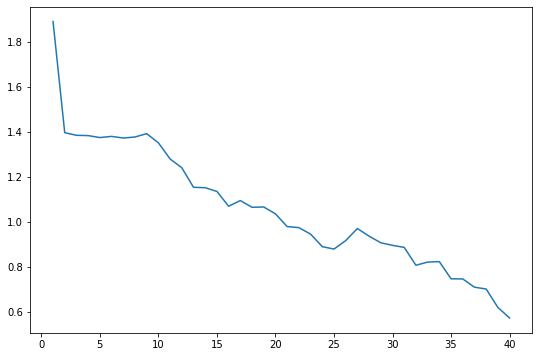

In [20]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_dandc.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist_dandc.history['loss'])
plt.plot(epochs, Hist_dandc.history['val_loss'])

plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()

- Accuracy Visualization

ValueError: ignored

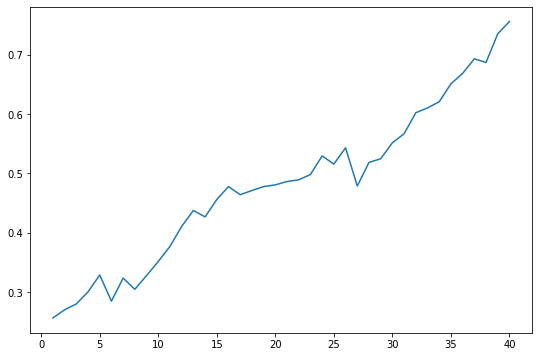

In [23]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_dandc.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist_dandc.history['accuracy'])
plt.plot(epochs, Hist_dandc.history['val_accuracy'])

plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')


### 5) Model Evaluate

- test_generator

In [24]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
                 test_dir,
                 target_size = (150, 150),
                 batch_size = 20,
                 class_mode = 'categorical')

Found 704 images belonging to 4 classes.


- Loss & Accuracy

In [25]:
loss, accuracy = model.evaluate(test_generator,
                                steps = 50)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

36/50 [====================>.........] - ETA: 26s - loss: 1.6456 - accuracy: 0.4347

50/50 [==============================] - 68s 1s/step - loss: 1.6456 - accuracy: 0.4347
Loss = 1.64560
Accuracy = 0.43466
